In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers

## Load Data
Define a function that imports all the data from the provided csv files

In [2]:
csv_paths = glob.glob("data/*.csv")
csv_filenames = [os.path.splitext(os.path.basename(x))[0] for x in csv_paths]

def load_data_from_csv():
    """Loads the csv files to pandas DataFrames and saves
    them in a dictionary with their filenames as keys"""
    data = dict()
    for csv_filename, csv_path in zip(csv_filenames, csv_paths):
        data[csv_filename] = pd.read_csv(csv_path)
    return data

# Load the data to a Dictionary
data = load_data_from_csv()

Inspect the data, the schema is shown below:

<img src="docs/schema.png">

First replace the chinese brands with their english names

In [3]:
# Join chinese brand names to their english equivalents
phone_brand_device_model = pd.merge(data["phone_brand_device_model"],
                                    data["chinese_to_english_brand"],
                                    left_on="phone_brand", right_on="chinese_brand", how="left")

# Fill nans for brands already in english
phone_brand_device_model["brand"] =\
    phone_brand_device_model["brand"].where(phone_brand_device_model["brand"].str.isalpha(),
                                                    phone_brand_device_model["phone_brand"].str.lower())

# We will just work with device brand and model for the time being
device_data = phone_brand_device_model[["device_id", "brand", "device_model"]]
device_data

,device_id,brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2
...,...,...,...
187240,7979541072208733273,xiaomi,MI 4
187241,-187404680852357705,xiaomi,红米2
187242,-2718274279595622821,xiaomi,MI 3
187243,3098391762071677791,vivo,X1


We can encode the brand and device model data

In [4]:
encoder = LabelEncoder().fit(device_data["brand"] + " " + device_data["device_model"])

device_data["encoded_brand_model"] = encoder.transform(device_data["brand"] + " " + device_data["device_model"])

device_data.sort_values(by=["encoded_brand_model"])

<ipython-input-4-09855a868b17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_data["encoded_brand_model"] = encoder.transform(device_data["brand"] + " " + device_data["device_model"])


,device_id,brand,device_model,encoded_brand_model
123784,5014627883795280526,AUX,V965T,0
71804,-231815432814429273,AUX,V965T,0
67660,-4567000646686758042,AUX,V965T,0
75906,8567026160899753334,AUX,V965T,0
34250,5489607796787403797,AUX,V965T,0
...,...,...,...,...
144356,-2217351983095398459,首云,P1,1664
163118,-1527969048433963834,首云,P1,1664
98617,-6315989391792706778,鲜米,S970,1665
26395,7388463854850737017,鲜米,s800,1666


In [5]:
print(f'There are {len(device_data["device_id"].unique())} unique devices in the device data')
# Get rid of duplicates in the device data
device_data_cln = device_data.drop_duplicates("device_id")
print(len(device_data_cln))

There are 186716 unique devices in the device data
186716


We'll proceed to join the device brand data to the train data

In [6]:
combined_data = data["gender_age_train"]
print(len(combined_data))
combined_data = pd.merge(combined_data, device_data_cln, on="device_id", how="left")
combined_data

74645


,device_id,gender,age,group,brand,device_model,encoded_brand_model
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,1565
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,1565
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,1565
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,1587
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,1569
...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,1569
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,1569
74642,180946546684162312,M,20,M22-,xiaomi,红米note,1587
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,873


# Approach 1

Since most of the devices do not have event data we will first attempt to infer gender and age using only the device brand and model data

In [56]:
FEATURE_COLUMNS = ["encoded_brand_model"]
LABELS = ["group"]

# Prepare the labels
y = combined_data[LABELS]
#y = pd.get_dummies(y, prefix='', prefix_sep='')
le = LabelEncoder()
le.fit(y.to_numpy().ravel())
y_enc = le.transform(y)
y_enc

y_cat = tf.keras.utils.to_categorical(y_enc)

In [57]:
y_cat

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [58]:
# Prepare the features
X = combined_data[FEATURE_COLUMNS]
X = pd.get_dummies(X, columns=['encoded_brand_model'], prefix='', prefix_sep='')
X_enc = X.to_numpy()
X_enc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Split dataset into train, validation and test sets.

In [59]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_cat, test_size=0.2, random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

44787 train examples
14929 validation examples
14929 test examples


In [89]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(max(y_enc)+1, activation="softmax", input_shape=(1486,)),  # input shape required
])

In [66]:
predictions = model(X_train)
predictions[:5]

<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0.08131057, 0.0826072 , 0.08304145, 0.0803363 , 0.08583712,
        0.08591978, 0.0859898 , 0.08732203, 0.07821   , 0.08182152,
        0.08051709, 0.08708717],
       [0.08148307, 0.08147891, 0.08485585, 0.08144684, 0.08630478,
        0.08136812, 0.08592186, 0.07967269, 0.07993848, 0.08539891,
        0.08624551, 0.08588503],
       [0.08797599, 0.08855978, 0.08815404, 0.08101559, 0.08061694,
        0.08122337, 0.08292546, 0.08677901, 0.08305321, 0.08138952,
        0.07885856, 0.07944852],
       [0.08593096, 0.08487701, 0.08824363, 0.08175492, 0.08305299,
        0.08234487, 0.08638471, 0.07949685, 0.08001188, 0.08062702,
        0.08501509, 0.0822601 ],
       [0.08348065, 0.08445558, 0.07968127, 0.08567343, 0.08246151,
        0.08487509, 0.083421  , 0.08064364, 0.08043794, 0.08391467,
        0.08611156, 0.08484357]], dtype=float32)>

In [75]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0.08343219, 0.08136921, 0.08069719, 0.08297601, 0.08226795,
        0.08143874, 0.08460085, 0.08653984, 0.08226136, 0.08533723,
        0.08587567, 0.08320387],
       [0.09661708, 0.08092841, 0.07906027, 0.08236992, 0.07781509,
        0.07872095, 0.09040973, 0.09181649, 0.08294676, 0.07842313,
        0.08142453, 0.07946754],
       [0.07710946, 0.07869662, 0.07891707, 0.07939371, 0.08351395,
        0.08006269, 0.08138499, 0.08162993, 0.08285338, 0.08842213,
        0.09388267, 0.09413341],
       [0.08115514, 0.08033181, 0.08010587, 0.08297417, 0.08175333,
        0.080139  , 0.0834097 , 0.08743416, 0.08276112, 0.08822932,
        0.08568333, 0.08602313],
       [0.07851811, 0.0796451 , 0.07716011, 0.08026454, 0.0819049 ,
        0.08000746, 0.08198038, 0.09076534, 0.0839224 , 0.08699773,
        0.09334498, 0.0854889 ]], dtype=float32)>

In [96]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy", "val_accuracy"])

In [97]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10


ValueError: in user code:

    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:543 train_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:391 update_state
        self._build(y_pred, y_true)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:321 _build
        self._metrics = nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\nest.py:1114 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\nest.py:1213 map_structure_with_tuple_paths_up_to
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\nest.py:1213 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\nest.py:1116 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:421 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:421 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:440 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\metrics.py:3358 get
        return deserialize(str(identifier))
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\metrics.py:3345 deserialize
        return deserialize_keras_object(
    C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:392 deserialize_keras_object
        raise ValueError('Unknown ' + printable_module_name + ':' + object_name)

    ValueError: Unknown metric function:val_accuracy


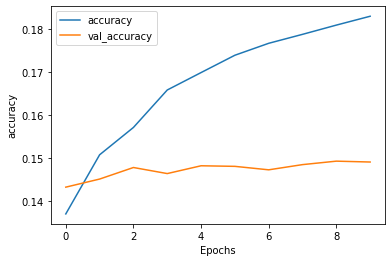

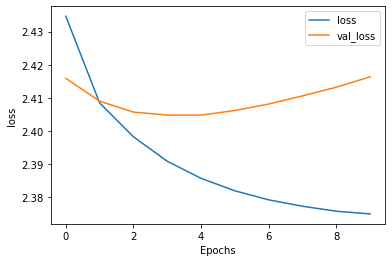

In [98]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [71]:
print(y_test[:20])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [72]:
predictions = model.predict(X_test)

In [102]:
from sklearn.metrics import log_loss

score_val = log_loss(y_test, predictions)
print("No-events: Logistic logloss is {}".format(score_val))

No-events: Logistic logloss is 29.57392850533482


In [101]:
predictions = (predictions == predictions.max(axis=1)[:,None]).astype(int)

In [104]:
import sys
np.set_printoptions(threshold=sys.maxsize)

print(predictions[0:20])

[[0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0]]


In [74]:
print(np.where(predictions[0:20] > 0.5, 1, 0))

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
